### CPS_Labor_Market_Grapher

Updated: April 9, 2018 

Brian Dew, @bd_econ

-----

Make decent looking line graphs for various labor market indicators.

TO DO:

Usual weekly hours as an option.

Quarterly uwe converted to real (no 12m ma)

Add option to return either nominal, contribution to total (if applicable), or share of total

UHE/UWE -- try to match with other published data

In [1]:
# Preliminaries--load packages and settings
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)
import pandas as pd
import numpy as np
import wquantiles

# Recession start and end months, from NBER
rec_dt = [('2001-04-01', '2001-12-01'), ('2008-01-01', '2009-07-01')]

In [2]:
# Consumer Price Index to adjust nominal prices
cpi = pd.read_csv('cpi.csv')
cpi.index = pd.to_datetime(cpi.DATE)

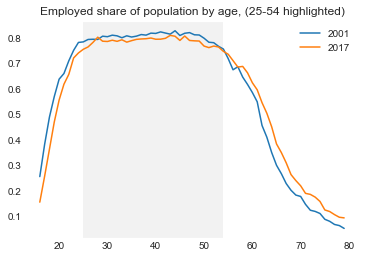

In [2]:
# Mini example of how labor force has aged
d = {}
for year in [2001, 2017]:
    d[year] = {}
    df = pd.read_feather(f'data/cps_{year}.ft', nthreads=3)
    for age in range (16, 80):
        dft = df[df['PRTAGE'] == age]
        empl = np.where(dft['PREMPNOT'] == 1, 1.0, 0.0)
        epop = np.average(empl, weights=dft['PWCMPWGT'])
        d[year][age] = epop
        
ax = pd.DataFrame(d).plot(title='Employed share of population by age, (25-54 highlighted)')
ax = plt.axvspan(25, 54, fill=True, linewidth=0, color='gray', alpha=0.1) 

In [14]:
# Functions that get labor force data from the CPS and graph it
def get_cps_data(filters, calc_type, decile=0.5, rtype='share'):
    """Filter the database and calculate labor market stat"""
    data = pd.Series()
    for year in range(1994, 2019):
        d = pd.read_feather(f'data/cps_{year}.ft', nthreads=3)
        for month in range(1, 13):
            df = d[(d['HRMONTH'] == month)]
            if len(df) > 0:
                df = df.query(filters)
                if calc_type == 'epop':
                    empl = np.where(df['PREMPNOT']==1, 1, 0)
                    epop = np.average(empl, weights=df['PWSSWGT'])
                    data[pd.to_datetime(f'{year}-{month}-01')] = epop * 100
                if calc_type == 'unemp':
                    un = np.where(df['PREMPNOT']==2, 1, 0)
                    lf = np.where(df['PREMPNOT'].isin([1, 2]), 1, 0)
                    unrt = (df['PWSSWGT'] * un).sum() / (df['PWSSWGT'] * lf).sum()
                    data[pd.to_datetime(f'{year}-{month}-01')] = unrt * 100
                if calc_type == 'lfpr':
                    lf = np.where(df['PREMPNOT'].isin([1, 2]), 1, 0)
                    unrt = (df['PWSSWGT'] * lf).sum() / (df['PWSSWGT']).sum()
                    data[pd.to_datetime(f'{year}-{month}-01')] = unrt * 100
                if calc_type == 'total':
                    if rtype == 'level':
                        tot = (df['PWSSWGT'] / 100000000).sum() / 100
                    else:
                        tot = (df['PWSSWGT']).sum() / (d[(d['HRMONTH'] == month)]['PWSSWGT']).sum() * 100
                    data[pd.to_datetime(f'{year}-{month}-01')] = tot
                # Following based on:
                # https://www.frbatlanta.org/chcs/human-capital-currents/2015/0612-measuring-labor-market-status-using-basic-data.aspx
                if calc_type == 'disc':
                    dw = np.where(df['PEDWWNTO'].isin([1]), 1, 0)
                    if rtype == 'level':
                        dwrt = ((df['PWSSWGT'] / 100000000) * dw).sum() / 100
                    else:
                        dwrt = (df['PWSSWGT'] * dw).sum() / (df['PWSSWGT']).sum() * 100
                    data[pd.to_datetime(f'{year}-{month}-01')] = dwrt 
                if calc_type == 'nilfsch':
                    ns = np.where((df['PRWNTJOB']==2) & (df['PENLFACT']==3), 1, 0)
                    if rtype == 'level':
                        scrt = ((df['PWSSWGT'] / 100000000) * ns).sum() / 100
                    else:
                        scrt = (df['PWSSWGT'] * ns).sum() / (df['PWSSWGT']).sum() * 100
                    data[pd.to_datetime(f'{year}-{month}-01')] = scrt
                if calc_type == 'disill':
                    nd = np.where(((df['PRWNTJOB']==2) & 
                                   ((df['PEMLR']==6) | 
                                    (df['PENLFACT']==1) | 
                                    (df['PENLFACT']==2))), 1, 0)
                    if rtype == 'level':
                        di = ((df['PWSSWGT'] / 100000000) * nd).sum() / 100
                    else:                    
                        di = (df['PWSSWGT'] * nd).sum() / (df['PWSSWGT']).sum() * 100
                    data[pd.to_datetime(f'{year}-{month}-01')] = di
                if calc_type == 'care':
                    care = np.where((df['PRWNTJOB']==2) & (df['PENLFACT']==4), 1, 0)
                    if rtype == 'level':
                        ncare = ((df['PWSSWGT'] / 100000000) * care).sum() / 100
                    else:                      
                        ncare = (df['PWSSWGT'] * care).sum() / (df['PWSSWGT']).sum() * 100 
                    data[pd.to_datetime(f'{year}-{month}-01')] = ncare
                if calc_type == 'union':
                    tot = np.where(df['PEERNLAB'].isin([1, 2]), 1, 0)
                    union = np.where(df['PEERNLAB'] == 1, 1, 0)
                    if rtype == 'level':
                        unsh = ((df['PWORWGT'] / 100000000) * union).sum() / 100
                    else:
                        unsh = (df['PWORWGT'] * union).sum() / (df['PWORWGT'] * tot).sum() * 100 
                    data[pd.to_datetime(f'{year}-{month}-01')] = unsh               
                if calc_type in ['uwe', 'uwe_gr', 'uwe_r']:
                    uwe = wquantiles.quantile(
                        df['PRERNWA'], df['PWORWGT'].astype(float), decile) / 100.0
                    data[pd.to_datetime(f'{year}-{month}-01')] = uwe
                if calc_type in ['uhe', 'uhe_gr', 'uhe_r']:
                    uhe = wquantiles.quantile(
                        df['PRERNHLY'], df['PWORWGT'].astype(float), decile) / 100.0
                    data[pd.to_datetime(f'{year}-{month}-01')] = uhe
        if calc_type in ['quwe_r', 'quwe']:
            for q in [('Q1', [1, 2, 3]), ('Q2', [4, 5, 6]), ('Q3', [7, 8, 9]), ('Q4', [10, 11, 12])]:
                df = d[(d['HRMONTH'].isin(q[1]))]
                if len(df['HRMONTH'].unique()) > 2:
                    df = df.query(filters)
                    quwe = wquantiles.quantile(
                        df['PRERNWA'], df['PWORWGT'].astype(float), decile) / 100.0
                    data[pd.to_datetime(f'{year}-{q[0]}')] = quwe
    # Growth if wage series
    if calc_type in ['uwe_gr', 'uhe_gr']:
        data = data.pct_change(12) * 100
    
    # Price adjustment for real wage series
    if calc_type in ['uwe_r', 'uhe_r', 'quwe_r']:
        data = pd.concat([data, cpi['CPIAUCSL']], axis=1)
        data = (data[0] * data['CPIAUCSL'].iloc[-1]) / data['CPIAUCSL']
        
    if calc_type not in ['quwe_r', 'quwe']:
        data = data.rolling(12).mean().dropna()
    
    # Take one-year moving average to smooth out seasonality and noise
    return data.dropna()

def labor_mkt_grapher(title, data, color):
    """Graph the labor market! """
    spcr, spcr2 = (data.max() - data.min()) / 26, (data.max() - data.min()) / 40
    ax = data.plot(title=title, figsize=(8, 4), color=color)
    ax = plt.scatter([data.index[-1]], [data[-1]], color=color, s=25)
    for i, v in rec_dt:
        ax = plt.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.2)  
    ax = plt.annotate(f'  {data[-1]: .1f}%', (data.index[-1], data[-1]-spcr2))
    ax = plt.annotate(f'  {data.index[-1]:%b %Y}', (data.index[-1], data[-1]+spcr), 
                      fontweight='bold')
    ax = plt.xlabel('Source: Current Population Survey, adjusted for inflation by CPI-U')

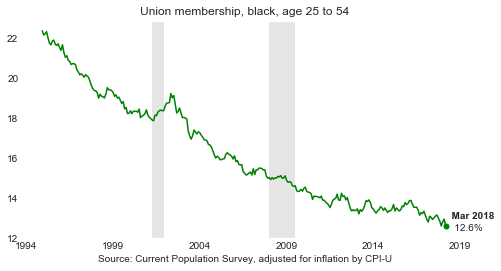

In [25]:
# Calculate total group size (millions)
filters = 'PRTAGE > 24 and PRTAGE < 55 and WBHAO == 2 '
calc_type = 'union'
title = 'Union membership, black, age 25 to 54'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'green')

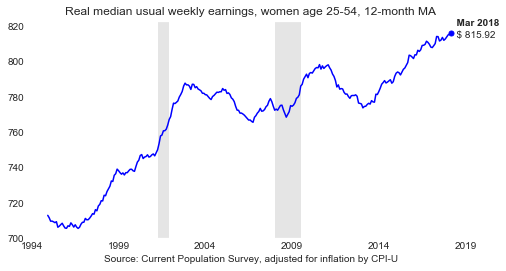

In [43]:
# Weekly wage growth
filters = 'PRTAGE > 24 and PRTAGE < 55 and PESEX == 2 and PRFTLF == 1 and PRERNWA > 0'
calc_type = 'uwe_r'
title = 'Real median usual weekly earnings, women age 25-54, 12-month MA'
data = get_cps_data(filters, calc_type, decile=0.5)
labor_mkt_grapher(title, data, 'blue')
plt.savefig('uwe.png', bbox_inches='tight', dpi=100)

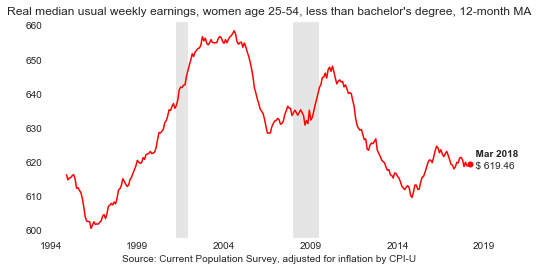

In [51]:
# Weekly wage growth
filters = 'PRTAGE > 24 and PRTAGE < 55 and PESEX == 2 and PRFTLF == 1 and PRERNWA > 0 and PEEDUCA < 43'
calc_type = 'uwe_r'
title = "Real median usual weekly earnings, women age 25-54, less than bachelor's degree, 12-month MA"
data = get_cps_data(filters, calc_type, decile=0.5)
labor_mkt_grapher(title, data, 'red')
plt.savefig('uwe_ba.png', bbox_inches='tight', dpi=100)

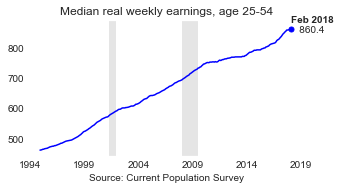

In [18]:
# Hourly wage growth
filters = 'PRERNWA > 0 and PRFTLF == 1'
calc_type = 'uwe'
title = 'Median real weekly earnings, age 25-54'
data = get_cps_data(filters, calc_type, decile=0.5)
labor_mkt_grapher(title, data, 'blue')

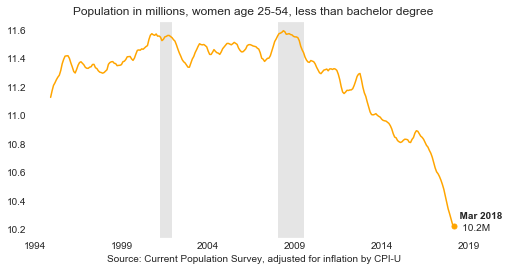

In [49]:
# Calculate total group size (millions)
filters = 'PRTAGE > 24 and PRTAGE < 55 and PESEX == 2 and PEEDUCA == 40'
calc_type = 'total'
title = 'Population in millions, women age 25-54, less than bachelor degree'
data = get_cps_data(filters, calc_type, rtype='level')
labor_mkt_grapher(title, data, 'orange')
#plt.savefig('pop_ltba.png', bbox_inches='tight', dpi=100)

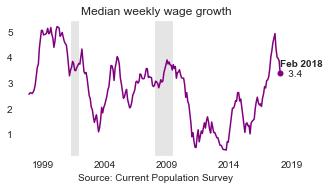

In [6]:
# Weekly wage growth
filters = 'PRFTLF == 1 and PRERNWA > 50'
calc_type = 'uwe'
title = 'Median weekly wage growth'
data = get_cps_data(filters, calc_type, decile=0.5)
labor_mkt_grapher(title, data, 'purple')

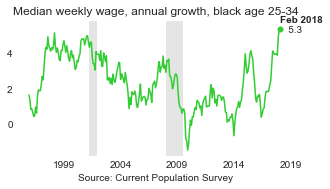

In [14]:
# Weekly wage growth
filters = 'PRTAGE > 24 and PRTAGE < 35 and WBHAO == 1 and PRFTLF == 1 and PRERNHLY > 0'
calc_type = 'uwe'
title = 'Median weekly wage, annual growth, black age 25-34'
data = get_cps_data(filters, calc_type, decile=0.5)
labor_mkt_grapher(title, data, 'limegreen')

In [33]:
pd.concat([data, cpi['CPIAUCSL']], axis=1)['CPIAUCSL'].iloc[-1]

249.61900000000003

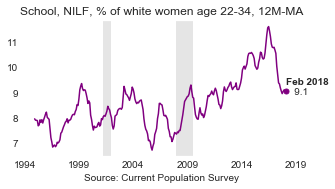

In [12]:
# Discouraged worker, or conditionally available
filters = 'PRTAGE > 22 and PRTAGE < 34 and PESEX == 2 and WBHAO == 4'
calc_type = 'nilfsch'
title = 'School, NILF, % of white women age 22-34, 12M-MA'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'purple')

The employment to population ratio calculates what share of the total population ($P$), has a job. It is calculated from the Current Population Survey (CPS).

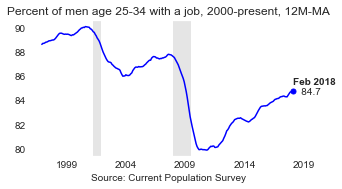

In [9]:
# Employment to Population Ratio
filters = 'PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 1'
calc_type = 'epop'
title = 'Percent of men age 25-34 with a job, 2000-present, 12M-MA'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

### The share of men age 25-34 with a job has not recovered from its 2000 peak

There are essentially three labor force categories: employed, unemployed, and not in the labor force.

$$Population = Employed + Unemployed + Not \ in \ Labor \ Force$$

The employment-population ratio (above) is therefore $\frac{Employed}{Population}$. $Unemployed$ and $Not \ in \ Labor \ Force$ are different; $Unemployed$ counts those actively looking for work or recently layed off. People can be outside the labor force for many reasons, some more subject to economic factors than others.

The CPS gives 100,000 people a chance to tell their story each month, including why they are not in the labor force. We can use the survey responses to summarize trends across groups.

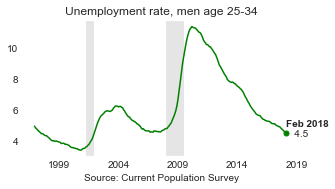

In [10]:
# Unemployment Rate
filters = 'PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 1'
calc_type = 'unemp'
title = 'Unemployment rate, men age 25-34'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'green')

The unemployment rate has more or less recovered, unlike the employment to population ratio. It is calculated as the unemployed population divided by the labor force, $\frac{Unemployed}{(Employed+Unemployed)}$. We can also look at the labor force participation rate, $\frac{(Employed+Unemployed)}{Population}$, the least recovered of the three measures. 

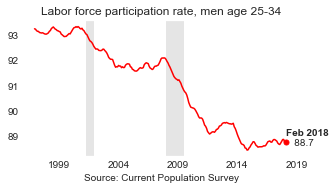

In [11]:
# Labor force participation rate
filters = 'PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 1'
calc_type = 'lfpr'
title = 'Labor force participation rate, men age 25-34'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'red')

### Women

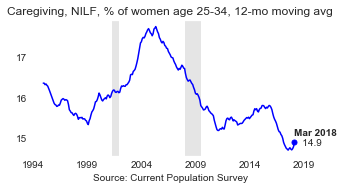

In [4]:
# Care for other, not in labor force
filters = 'PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 2'
calc_type = 'care'
title = 'Caregiving, NILF, % of women age 25-34, 12-mo moving avg'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'blue')
plt.savefig('caregiving.png', bbox_inches='tight', dpi=500)

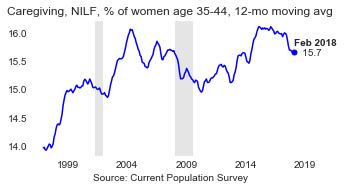

In [13]:
# Care for other, not in labor force
filters = 'PRTAGE >= 35 and PRTAGE <= 44 and PESEX == 2'
calc_type = 'care'
title = 'Caregiving, NILF, % of women age 35-44, 12-mo moving avg'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

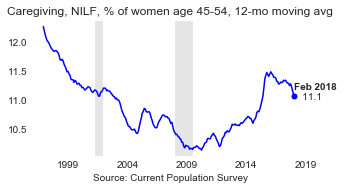

In [14]:
# Care for other, not in labor force
filters = 'PRTAGE >= 45 and PRTAGE <= 54 and PESEX == 2'
calc_type = 'care'
title = 'Caregiving, NILF, % of women age 45-54, 12-mo moving avg'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

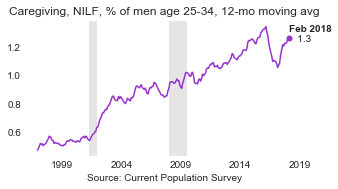

In [15]:
# Care for other, not in labor force
filters = 'PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 1'
calc_type = 'care'
title = 'Caregiving, NILF, % of men age 25-34, 12-mo moving avg'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'darkorchid')
plt.savefig('caregiving.png', bbox_inches='tight', dpi=500)

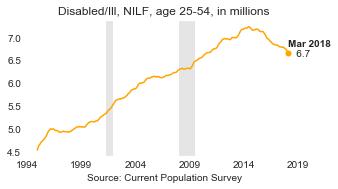

In [5]:
# Disabled/Ill, not in labor force
filters = 'PRTAGE >= 25 and PRTAGE <= 54'
calc_type = 'disill'
title = 'Disabled/Ill, NILF, age 25-54, in millions'
data = get_cps_data(filters, calc_type, rtype='level')
labor_mkt_grapher(title, data, 'orange')
plt.savefig('disill.png', bbox_inches='tight', dpi=100)

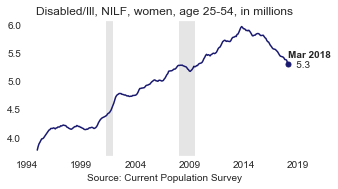

In [6]:
# Disabled/Ill, not in labor force
filters = 'PRTAGE >= 25 and PRTAGE <= 54 and PESEX == 2'
calc_type = 'disill'
title = 'Disabled/Ill, NILF, women, age 25-54, in millions'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'midnightblue')

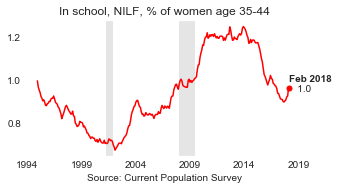

In [27]:
# In school, not in labor force
filters = 'PRTAGE >= 35 and PRTAGE <= 44 and PESEX == 2'
calc_type = 'nilfsch'
title = 'In school, NILF, % of women age 35-44'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'red')
plt.savefig('school3544women.png', bbox_inches='tight', dpi=100)

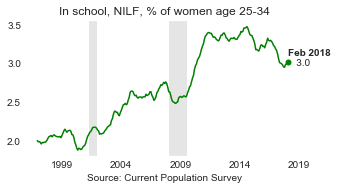

In [19]:
# In school, not in labor force
series = 'PENLFACT'
filters = 'PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 2'
calc_type = 'nilfsch'
title = 'In school, NILF, % of women age 25-34'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'green')

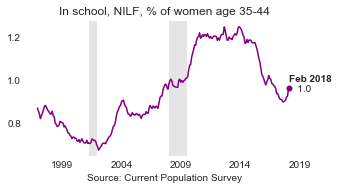

In [20]:
# In school, not in labor force
filters = 'PRTAGE >= 35 and PRTAGE <= 44 and PESEX == 2'
calc_type = 'nilfsch'
title = 'In school, NILF, % of women age 35-44'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'purple')

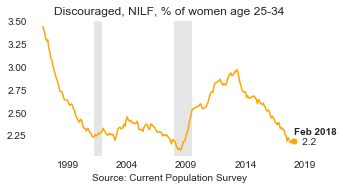

In [21]:
# Discouraged worker, or conditionally available
filters = 'PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 2'
calc_type = 'disc'
title = 'Discouraged, NILF, % of women age 25-34'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'orange')

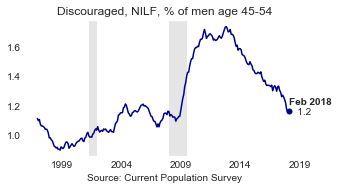

In [22]:
# Discouraged worker, or conditionally available
filters = 'PRTAGE >= 45 and PRTAGE <= 54 and PESEX == 1'
calc_type = 'disc'
title = 'Discouraged, NILF, % of men age 45-54'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'darkblue')

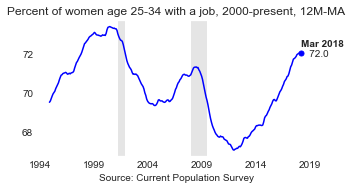

In [7]:
# Employment to Population Ratio
filters = 'PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 2'
calc_type = 'epop'
title = 'Percent of women age 25-34 with a job, 2000-present, 12M-MA'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

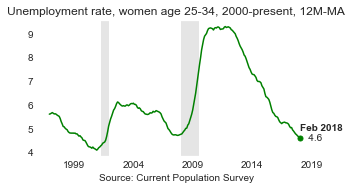

In [24]:
# Unemployment Rate
calc_type = 'unemp'
title = 'Unemployment rate, women age 25-34, 2000-present, 12M-MA'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'green')

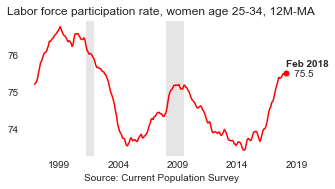

In [25]:
# Labor force participation rate
filters = 'PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 2'
calc_type = 'lfpr'
title = 'Labor force participation rate, women age 25-34, 12M-MA'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'red')
plt.savefig('lfpr.png', bbox_inches='tight', dpi=500)

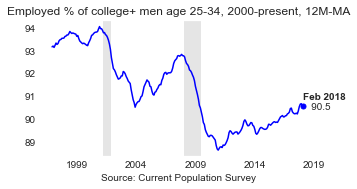

In [26]:
# Employment to Population Ratio
filters = 'PEEDUCA >= 43 and PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 1'
calc_type = 'epop'
title = 'Employed % of college+ men age 25-34, 2000-present, 12M-MA'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

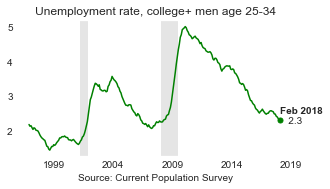

In [27]:
# Unemployment Rate
calc_type = 'unemp'
title = 'Unemployment rate, college+ men age 25-34'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'green')

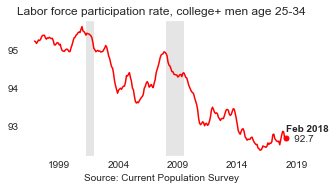

In [28]:
# Labor force participation rate
filters = 'PEEDUCA >= 43 and PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 1'
calc_type = 'lfpr'
title = 'Labor force participation rate, college+ men age 25-34'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'red')

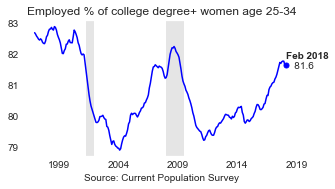

In [29]:
# Employment to Population Ratio
filters = 'PEEDUCA >= 43 and PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 2'
calc_type = 'epop'
title = 'Employed % of college degree+ women age 25-34'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

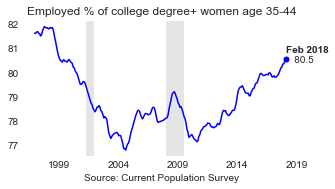

In [30]:
# Employment to Population Ratio
filters = 'PEEDUCA >= 43 and PRTAGE >= 35 and PRTAGE <= 44 and PESEX == 2'
calc_type = 'epop'
title = 'Employed % of college degree+ women age 35-44'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

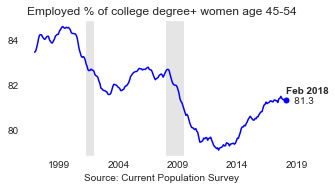

In [31]:
# Employment to Population Ratio
filters = 'PEEDUCA >= 43 and PRTAGE >= 45 and PRTAGE <= 54 and PESEX == 2'
calc_type = 'epop'
title = 'Employed % of college degree+ women age 45-54'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

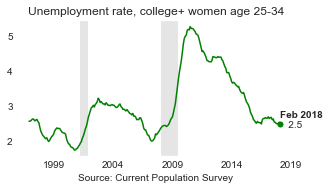

In [32]:
# Unemployment Rate
filters = 'PEEDUCA >= 43 and PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 2'
calc_type = 'unemp'
title = 'Unemployment rate, college+ women age 25-34'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'green')

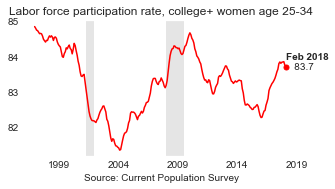

In [33]:
# Labor force participation rate
calc_type = 'lfpr'
title = 'Labor force participation rate, college+ women age 25-34'
data = get_cps_data(filters, calc_type)
labor_mkt_grapher(title, data, 'red')

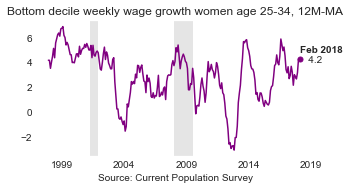

In [34]:
# Weekly wage growth
filters = 'PRFTLF == 1 and PRTAGE >= 25 and PRTAGE <= 34 and PESEX == 2 and PRERNWA > 0'
calc_type = 'uwe'
title = 'Bottom decile weekly wage growth women age 25-34, 12M-MA'
data = get_cps_data(filters, calc_type, decile=0.1)
labor_mkt_grapher(title, data, 'purple')

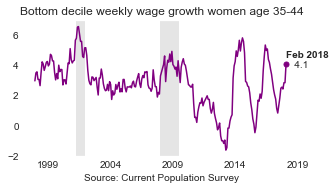

In [35]:
# Weekly wage growth
filters = 'PRFTLF == 1 and PRTAGE >= 35 and PRTAGE <= 44 and PESEX == 2 and PRERNWA > 0'
calc_type = 'uwe'
title = 'Bottom decile weekly wage growth women age 35-44'
data = get_cps_data(filters, calc_type, decile=0.1)
labor_mkt_grapher(title, data, 'purple')

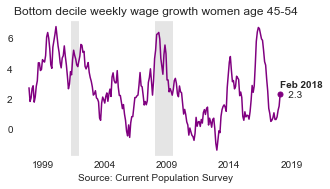

In [36]:
# Weekly wage growth
filters = 'PRFTLF == 1 and PRTAGE >= 45 and PRTAGE <= 54 and PESEX == 2 and PRERNWA > 0'
calc_type = 'uwe'
title = 'Bottom decile weekly wage growth women age 45-54'
data = get_cps_data(filters, calc_type, decile=0.1)
labor_mkt_grapher(title, data, 'purple')